## Classification

In [1]:
from IPython import get_ipython
if get_ipython():
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import latenta as la
la.logger.setLevel("INFO")

## Generative model

In [2]:
n_samples = 100
sample_ids = [str(i) for i in range(n_samples)]
sample_index = pd.Series(sample_ids, name = "cell")

x = la.Fixed(pd.Series(np.random.uniform(0, 3, n_samples), index = sample_index), label = "x")

In [3]:
n_clusters = 4
cluster_ids = [str(i) for i in range(n_clusters)]
cluster_index = pd.Series(cluster_ids, name = "feature")

beta = la.Fixed(pd.Series([-2, -2, 2, 2], index = cluster_index), label = "beta")

bias = la.Fixed(pd.Series([1, 1, -1, -1], index = cluster_index), label = "bias")

In [4]:
concentration = la.links.scalar.Linear(x, beta, b = bias, transforms = [la.transforms.Exp()])

In [5]:
probs = la.distributions.Dirichlet(concentration)

In [6]:
dist = la.distributions.OneHotCategorical(probs)


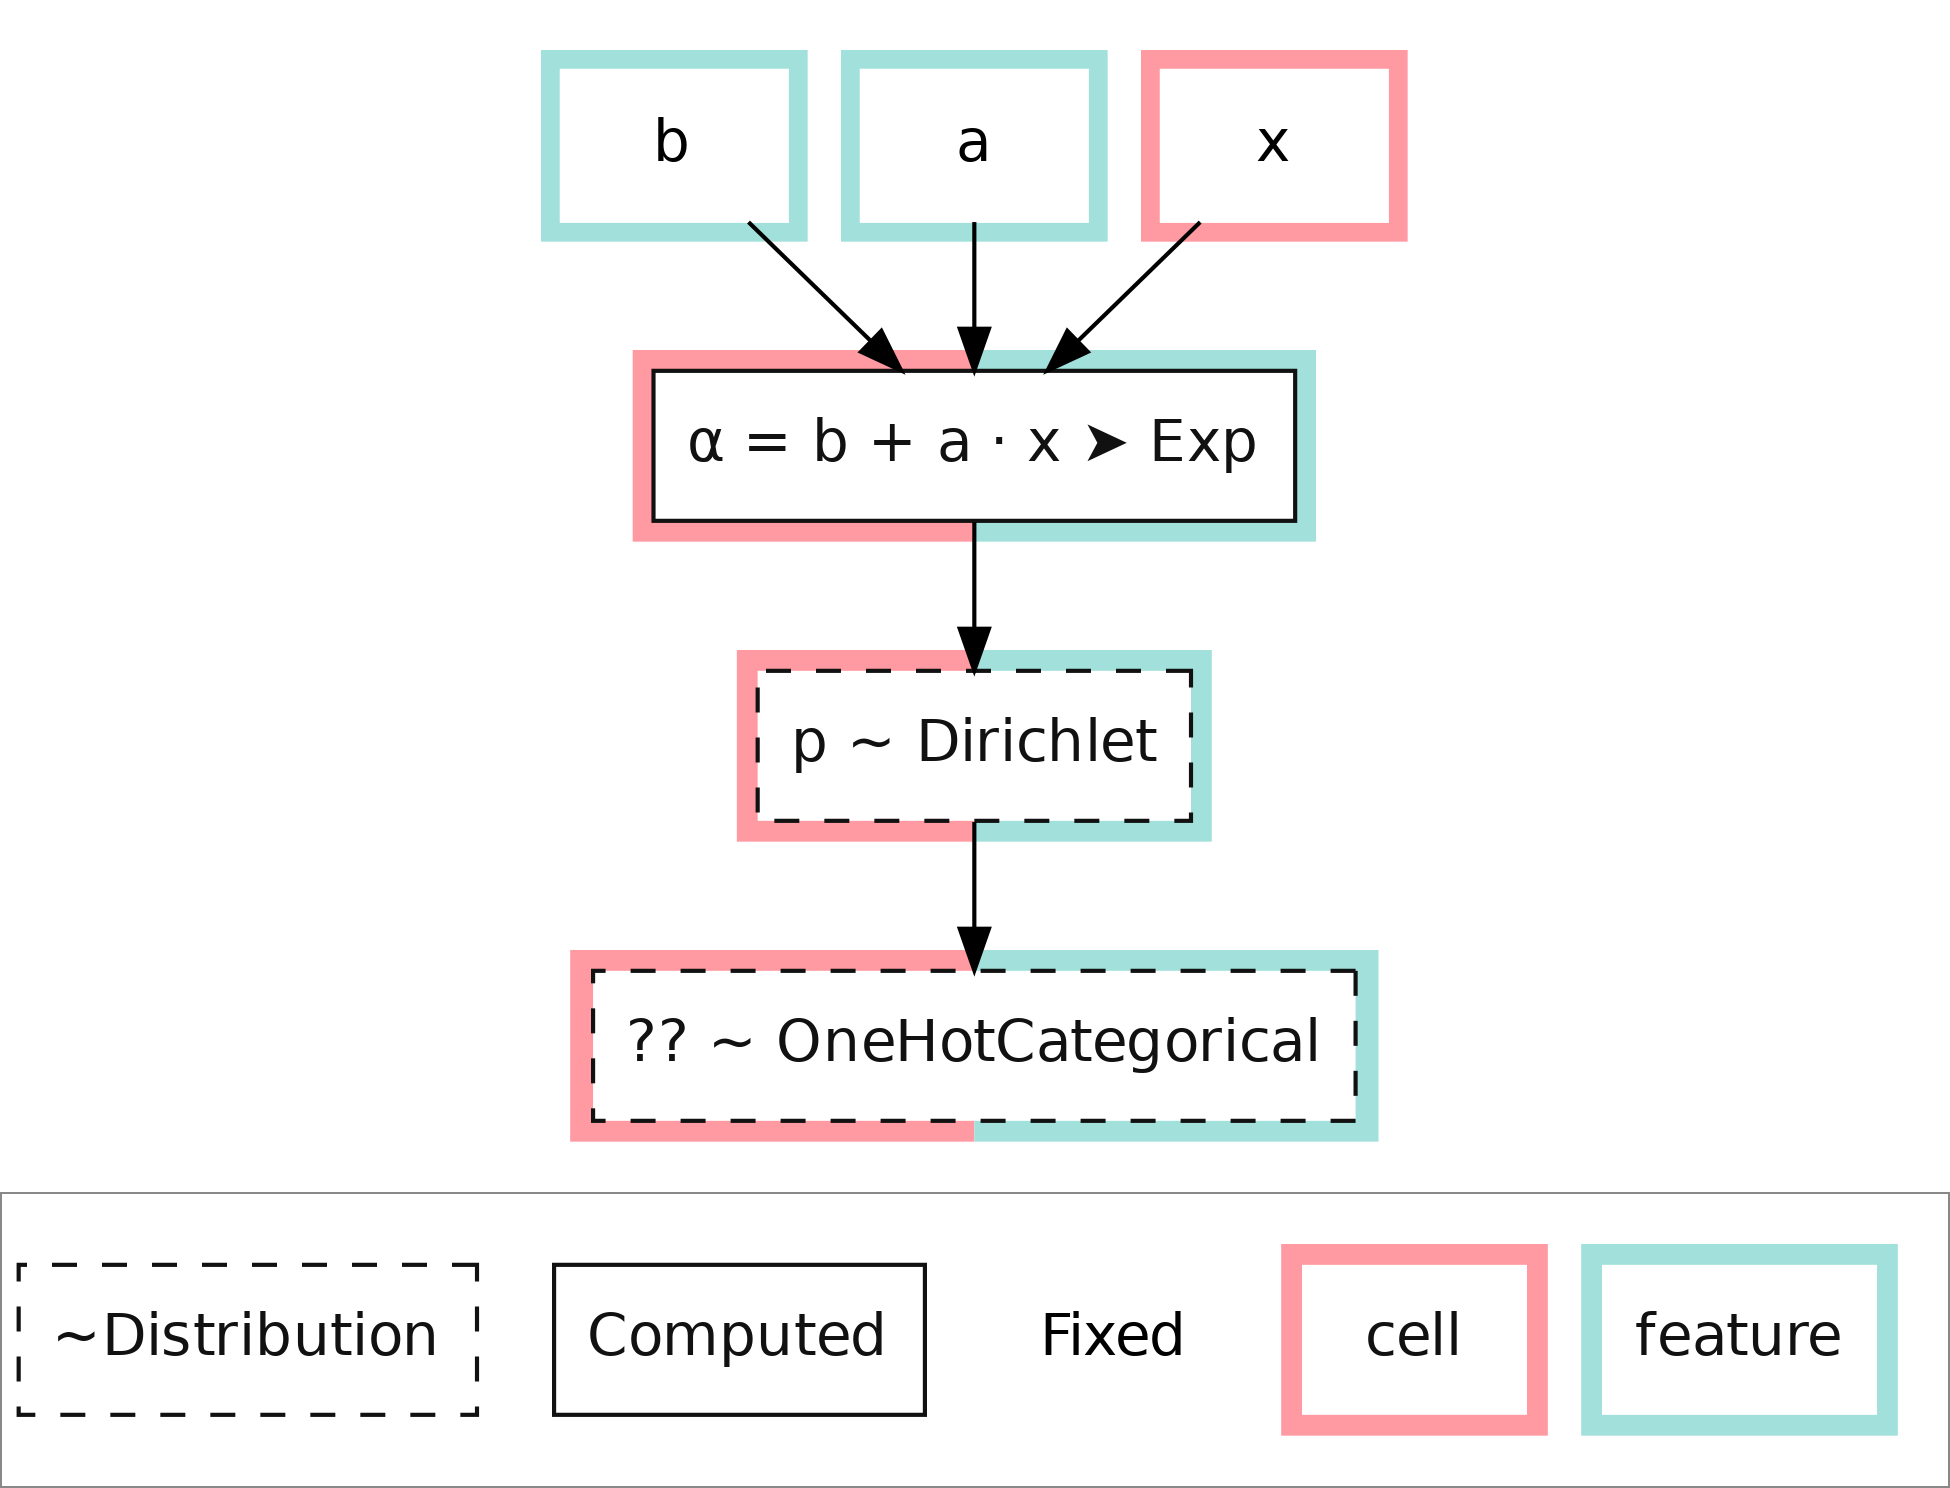

In [7]:
dist.plot()

In [8]:
posterior = la.posterior.Posterior(dist)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='feature', ylabel='cell'>

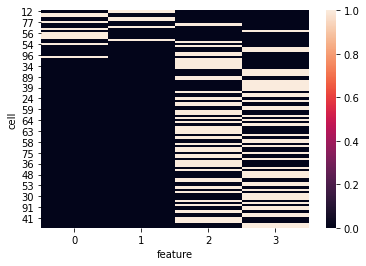

In [9]:
observation_value = posterior.samples[dist].sel(sample = 0).to_pandas()
sns.heatmap(observation_value.iloc[np.argsort(x.prior_pd())])

## Classification based on observed x

In [10]:
cluster_definition = la.Definition.from_xr(observation_value)

In [11]:
concentration = la.links.scalar.Linear(x, b = True, a = True, output = cluster_definition, transforms = [la.transforms.Exp()])

In [12]:
probs = la.distributions.Dirichlet(concentration)
onehot = la.distributions.OneHotCategorical(probs)
observation = la.Observation(observation_value, onehot, label = "observation")


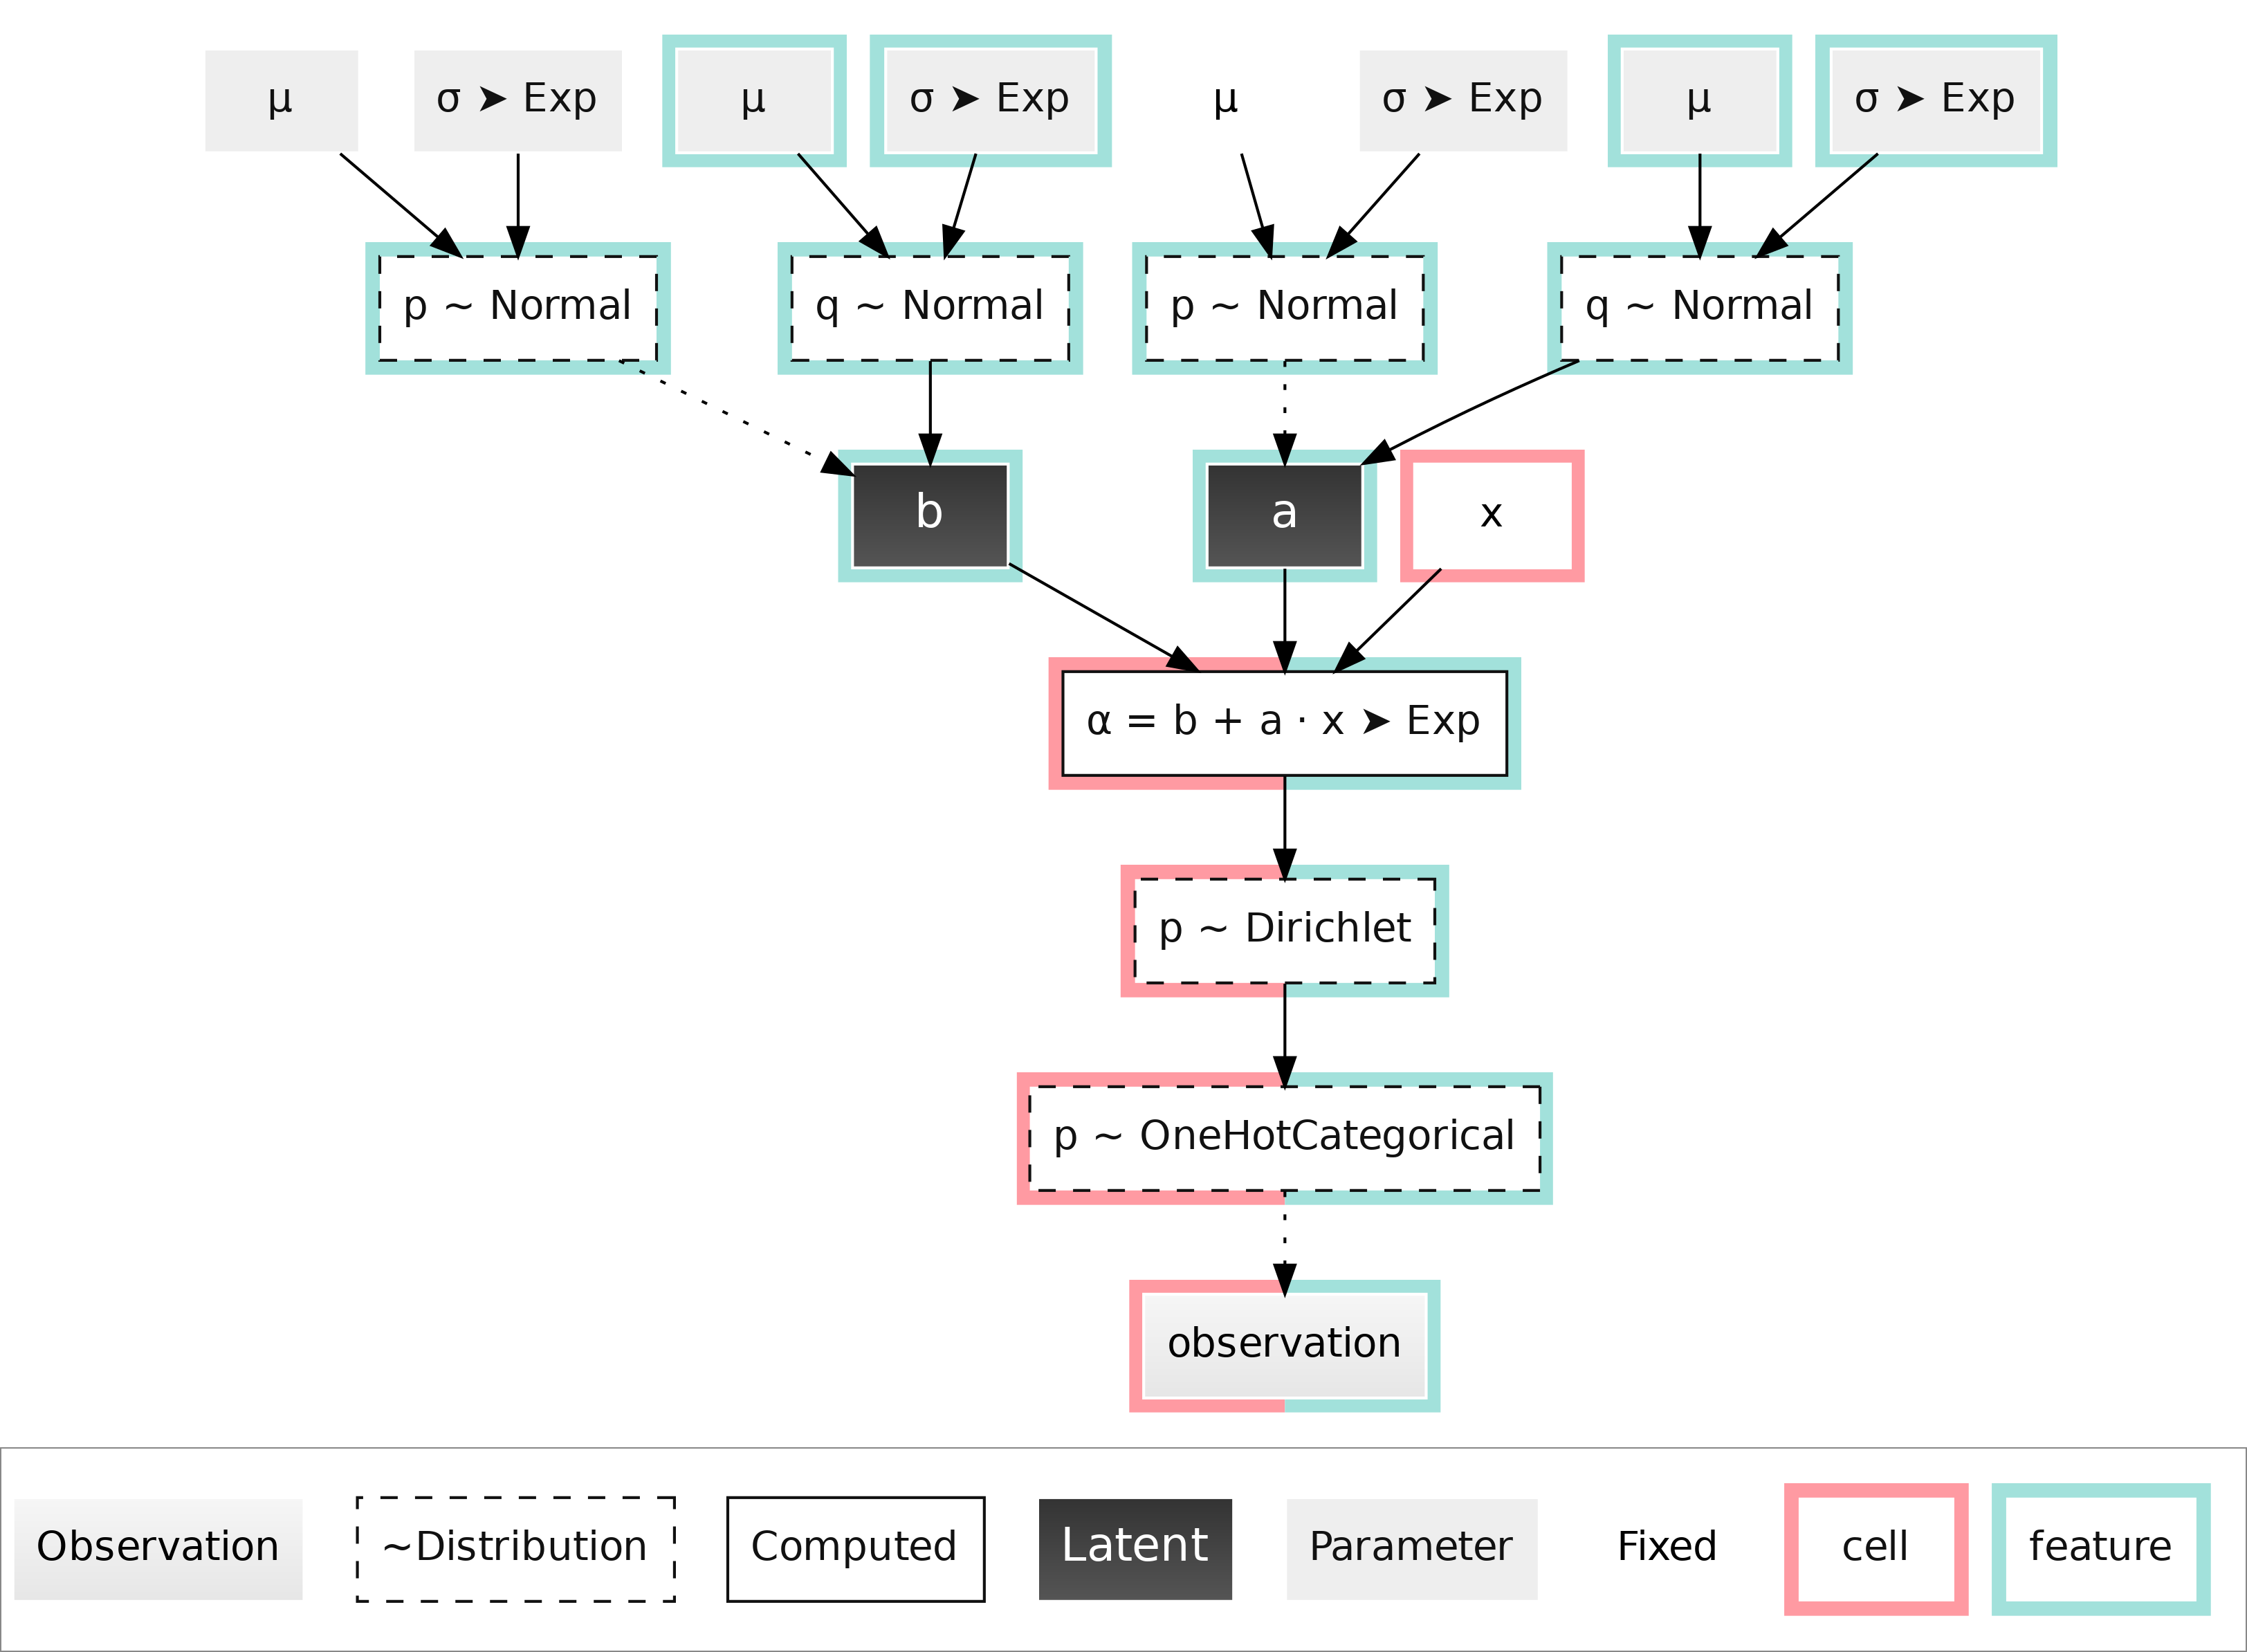

In [13]:
observation.plot()

In [14]:
model = la.Model(observation)

In [15]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [16]:
posterior = la.posterior.Posterior(observation)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='feature', ylabel='cell'>

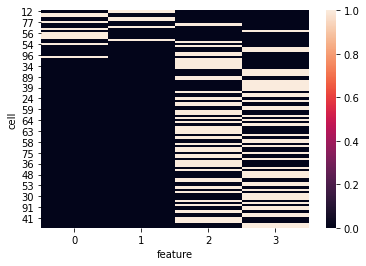

In [36]:
sns.heatmap(observation_value.iloc[np.argsort(x.prior().numpy())])

<AxesSubplot:xlabel='feature', ylabel='cell'>

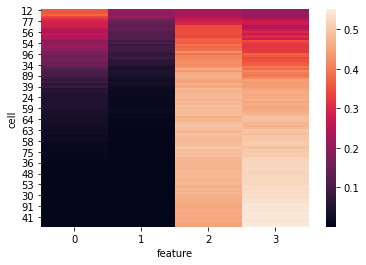

In [37]:
modelled_value = posterior.samples[probs].mean("sample").to_pandas()
sns.heatmap(modelled_value.iloc[np.argsort(x.prior().numpy())])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

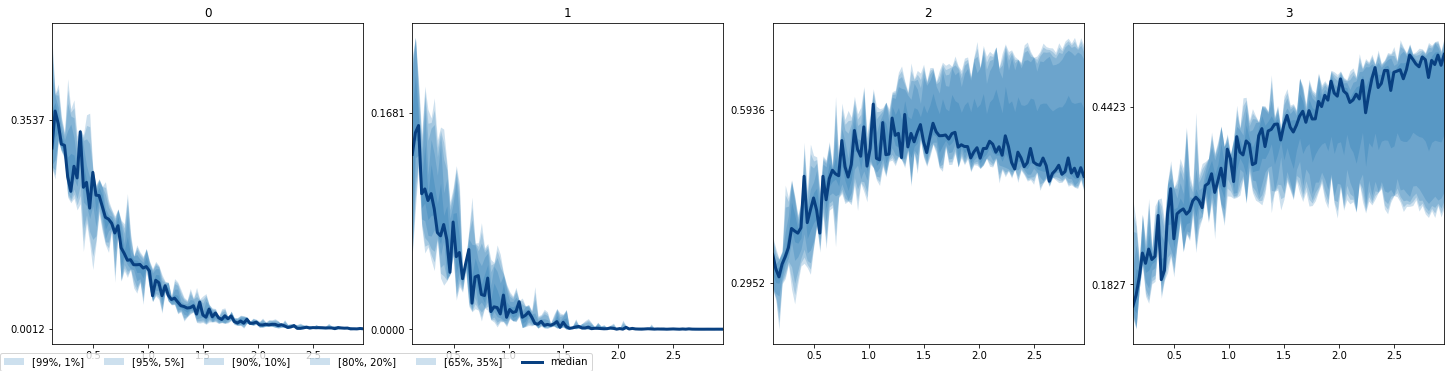

In [42]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.observed.sample(1)
causal.sample(5)
causal.plot_features(observation.p.probs);

## Classification based on observed x (2)

An example with softmax transform

In [43]:
probs = la.links.scalar.Linear(x, b = True, a = True, output = cluster_definition, transforms = [la.transforms.Softmax()])

In [44]:
onehot = la.distributions.OneHotCategorical(probs)
observation = la.Observation(observation_value, onehot, label = "observation")


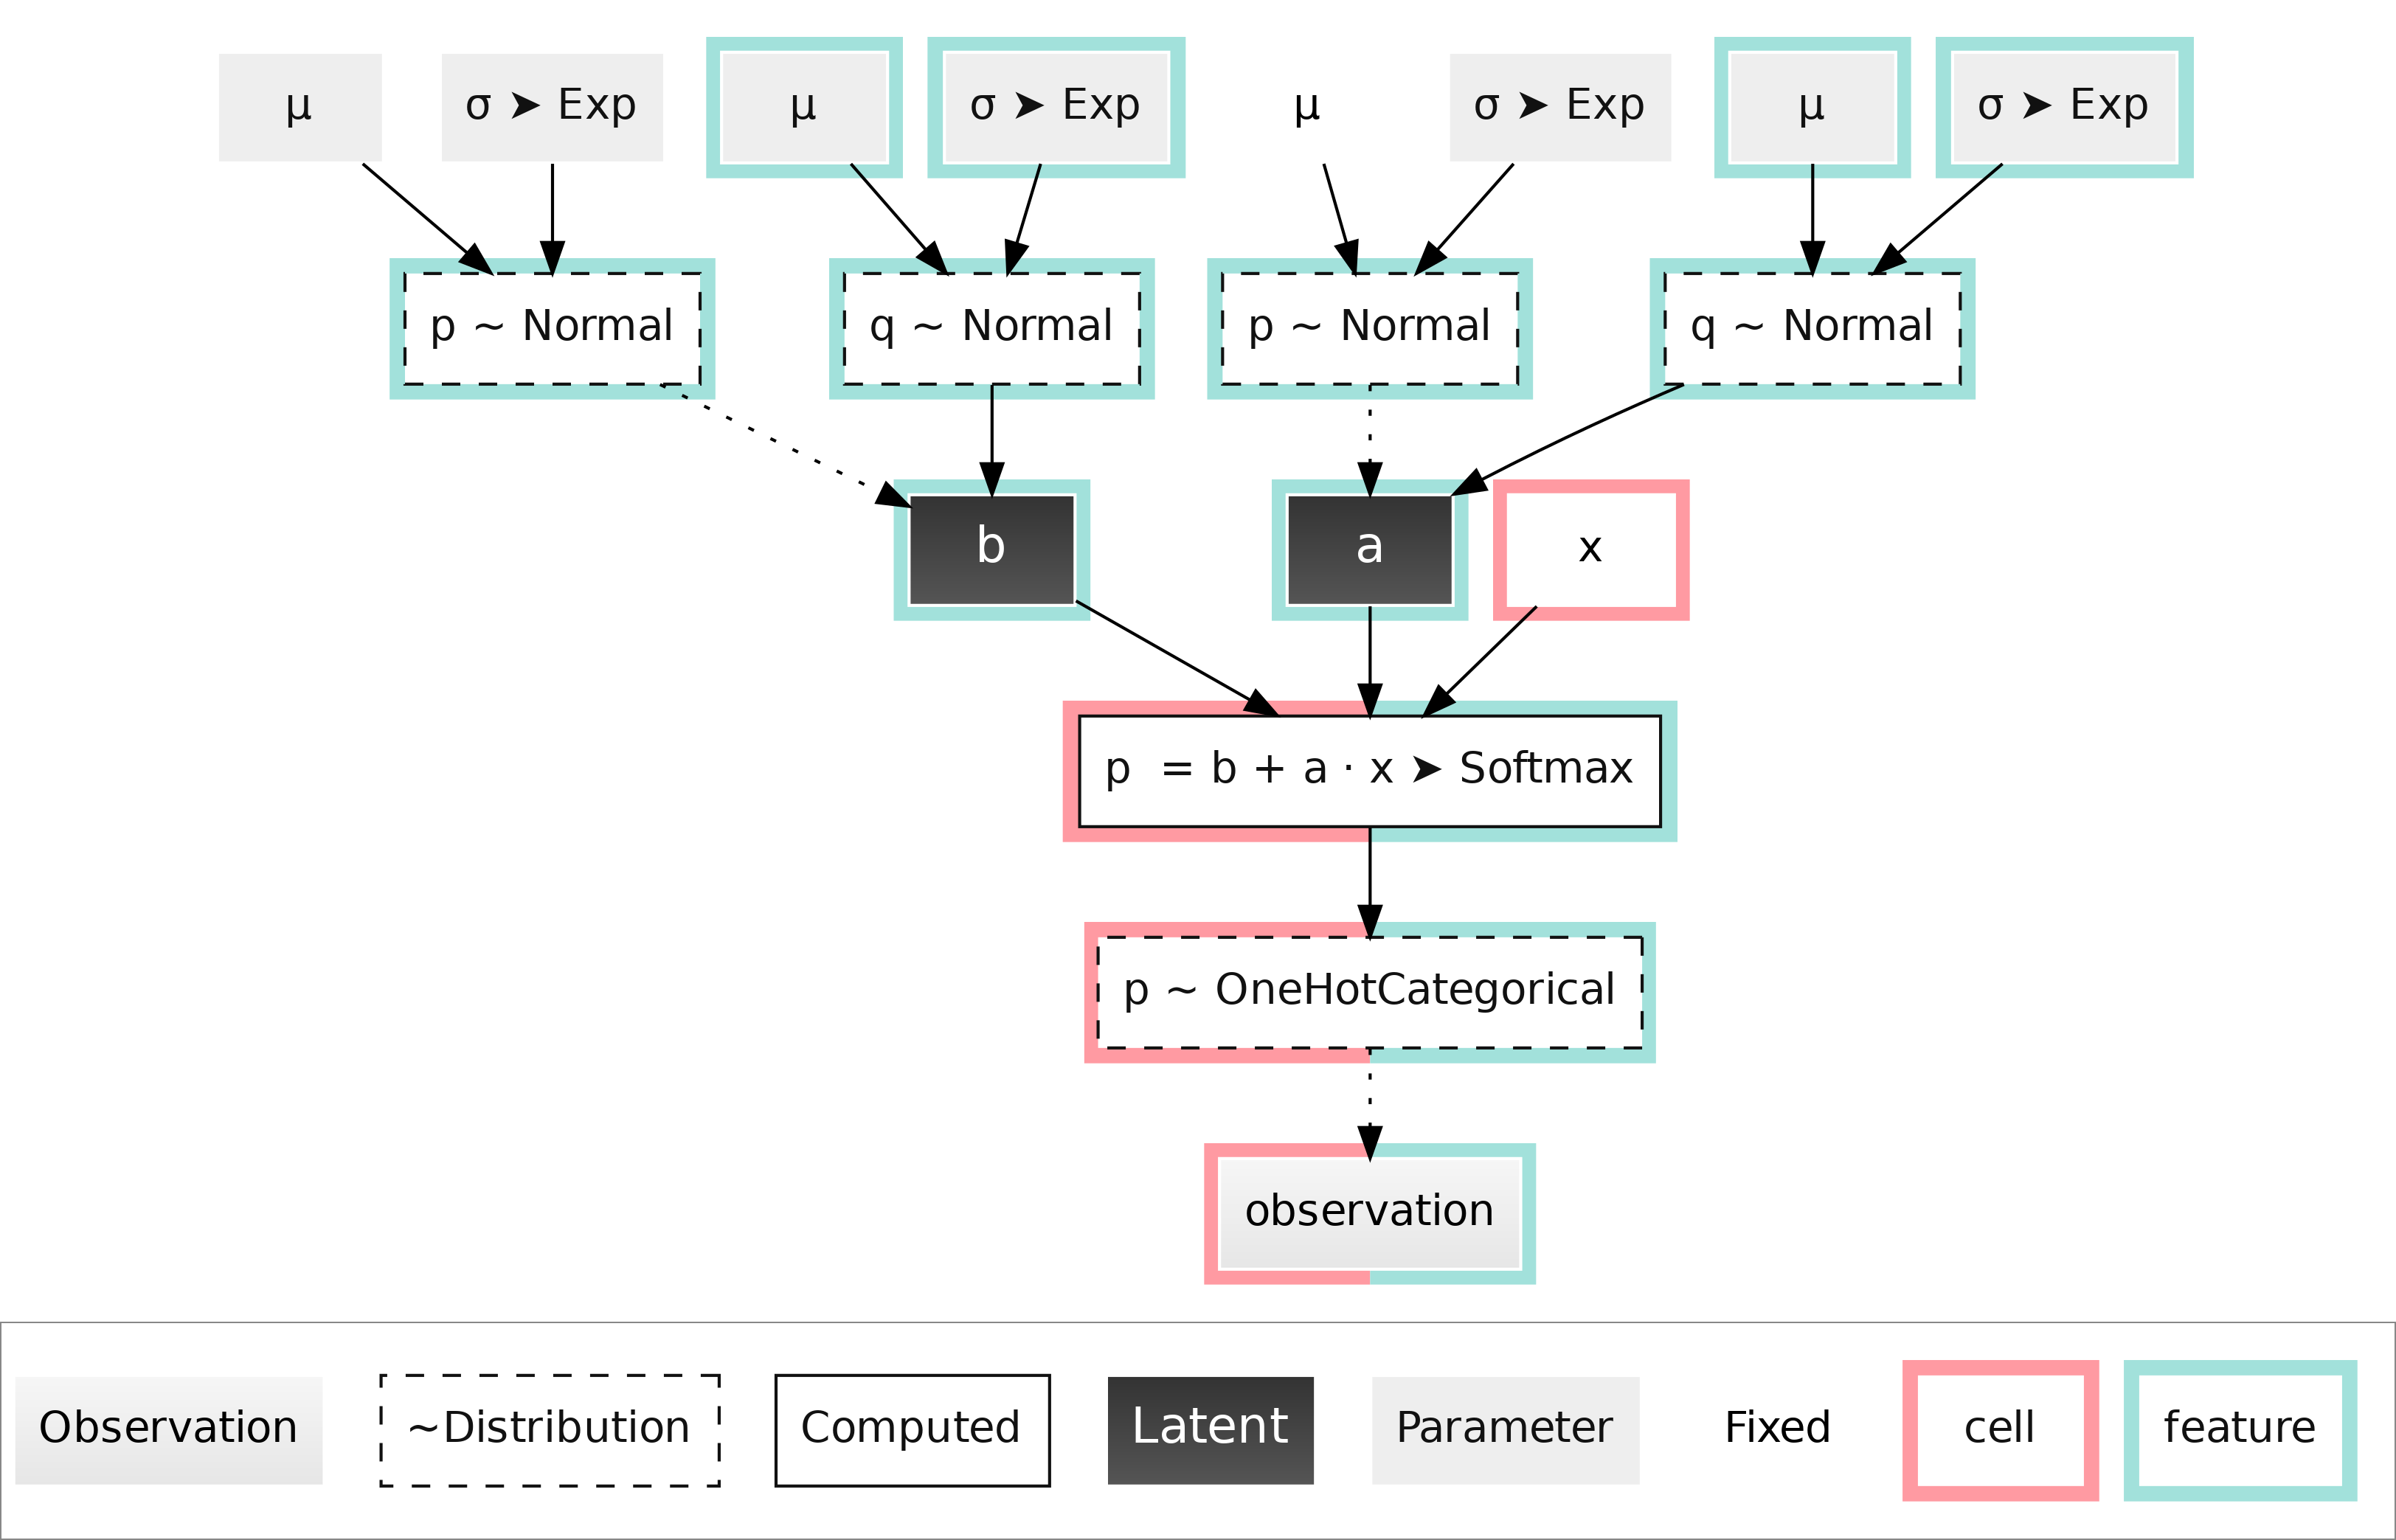

In [45]:
observation.plot()

In [46]:
model = la.Model(observation)

In [47]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)

In [48]:
trace = trainer.train(10000)

  0%|                                                                                                         …

In [49]:
posterior = la.posterior.Posterior(observation)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='feature', ylabel='cell'>

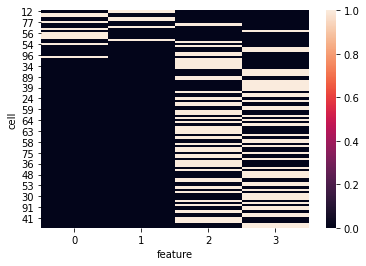

In [50]:
sns.heatmap(observation_value.iloc[np.argsort(x.prior().numpy())])

<AxesSubplot:xlabel='feature', ylabel='cell'>

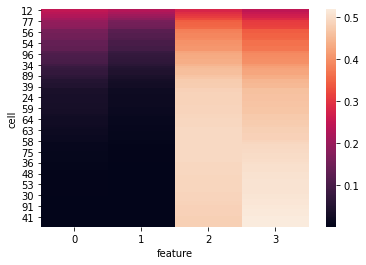

In [51]:
modelled_value = posterior.samples[probs].mean("sample").to_pandas()
sns.heatmap(modelled_value.iloc[np.argsort(x.prior().numpy())])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

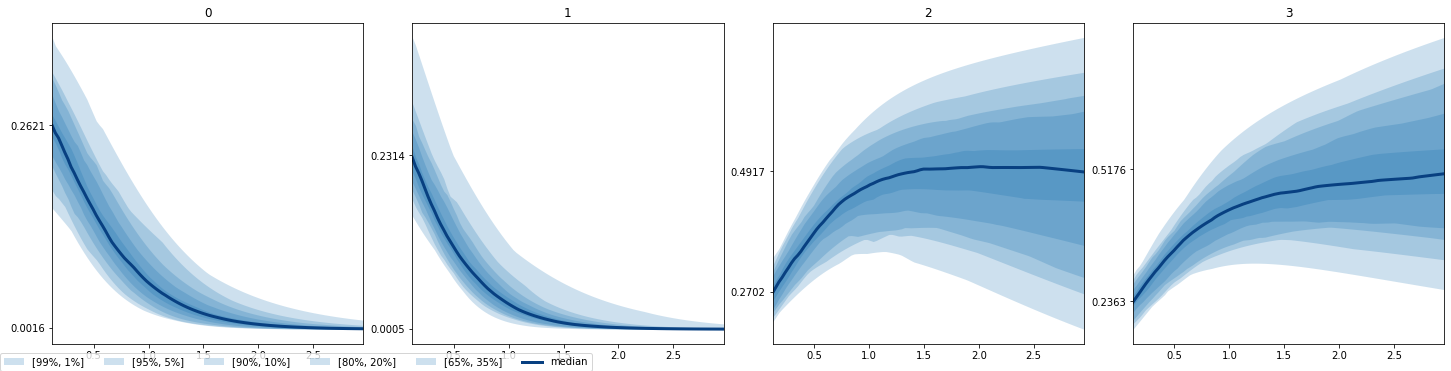

In [52]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.observed.sample(1)
causal.sample(100)
causal.plot_features();

## Classification using latent x

This doesn't really work, given that we try to predict a single discrete variable using a continuous variable. See the combined regression + classification example for where this can work